In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """
    Multiplies a and b.

    Args:
        a: The first number to multiply.
        b: The second number to multiply.

    Returns:
        The product of a and b.
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [21]:
result = llm_with_tools.invoke("Which ocean has the mosty variety of marine life?")

In [22]:
print(result)

content='The Pacific Ocean is known to have the most variety of marine life. Spanning more than 63 million square miles, it is the largest and deepest ocean on Earth. The Pacific Ocean hosts a diverse range of ecosystems, including coral reefs, deep-sea environments, and coastal habitats, which contribute to its rich biodiversity. Many species found in the Pacific are unique to specific regions, making it a critical area for marine biodiversity.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 85, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None} id='run-57dfd7dd-82ee-46f9-a929-0bdba4ba91bd-0' usage_metadata={'input_tokens': 85,

In [13]:
from typing import Annotated
from langgraph.graph.message import add_messages
from typing import TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage


class Messages(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [23]:
from langgraph.graph import END, START, StateGraph
from typing import Literal
from langgraph.prebuilt import ToolNode, tools_condition


#node 
def tool_call_decide_node(state: Messages):
    """
    Based on the state messages, decide if we need to call the tool or not.
    """
    return  {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

workflow = StateGraph(Messages)

workflow.add_node("tool_call_decide_node", tool_call_decide_node)
workflow.add_node("tools", ToolNode([multiply]))

workflow.add_edge(START, "tool_call_decide_node")
workflow.add_conditional_edges("tool_call_decide_node", tools_condition)
workflow.add_edge("tools", END)

graph = workflow.compile()

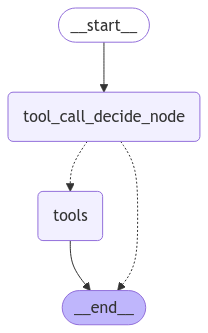

In [28]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
messages = graph.invoke({"messages": HumanMessage(content = "What is 2 times 3?", name = "Hrithik")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================
Name: Hrithik

What is 2 times 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vieEPQ1wtnGBVjdP1LiNZVVh)
 Call ID: call_vieEPQ1wtnGBVjdP1LiNZVVh
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [26]:
messages = graph.invoke({"messages": HumanMessage(content = "Which ocean has the mosty variety of marine life?", name = "Hrithik")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================
Name: Hrithik

Which ocean has the mosty variety of marine life?
================================== Ai Message ==================================

The Pacific Ocean is known to have the most variety of marine life. It is the largest and deepest ocean, spanning a vast area and encompassing a wide range of habitats, from coral reefs to deep-sea trenches. This diversity of environments contributes to the richness of marine species found in the Pacific, making it home to more marine organisms than any other ocean.
